In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### make a reference trajectory
from math import pi, cos, sin
theta = np.arange(0., 2*pi, 0.01)

traj1 = []
r1 = 0.1
for t in theta:
    traj1.append((r1 * cos(t) - r1, r1 * sin(t)))

traj2 = []
r2 = 0.5
for t in theta:
    traj2.append((r2 * cos(t+pi) + r2, r2 * sin(t+pi)))

ref_traj = np.vstack((traj1, traj2))
t = np.arange(0, 1, 1/1258).reshape(1258,1)

ref_traj = np.hstack((t, ref_traj))

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, trainable_std=False):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)
        
        if trainable_std:
            self.std = nn.Parameter(torch.exp(torch.ones(action_dim) * (-1)))
        else:
            self.std = torch.ones(action_dim) * 0.1 #torch.exp(torch.ones(action_dim) * (-2))
            
    def pi(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = torch.tanh(self.fc3(x))
        
        dist = torch.distributions.Normal(mean, self.std)
        actions = dist.sample()
        # actions = torch.clip(actions, -1, 1)
        log_probs = dist.log_prob(actions)
        return mean, actions, log_probs

    def get_prob(self, x, a):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = torch.tanh(self.fc3(x))
        
        dist = torch.distributions.Normal(mean, self.std)
        log_probs = dist.log_prob(a)
        
        entropy = dist.entropy()
        return log_probs, entropy
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        v = self.fc_v(x)
        return v

In [5]:
def train(model, optimizer, hist):
    gamma = 0.99
    tau = 0.95
    eps_clip = 0.2
    entropy_coeff = 0.0
    
    s_lst, a_lst, r_lst, s_prime_lst = [], [], [], []
    l = len(hist)
    param = model.parameters()
    for i in range(l):
        s, a, r, s_prime = hist[i]
        s_lst.append(s)
        a_lst.append(a)
        r_lst.append([r])
        s_prime_lst.append(s_prime)        
        
    
    with torch.no_grad():
        oldvalue_prime = model.v(torch.FloatTensor(s_prime_lst))
        oldvalue = model.v(torch.FloatTensor(s_lst))
        old_states = torch.Tensor(s_lst)
        old_actions = torch.Tensor(a_lst)
        rewards = torch.Tensor(r_lst)
        
        #td_targets = rewards + gamma * oldvalue_prime
        #advantages = td_targets - oldvalue
    
        gae = 0
        advantages = []
        for i in reversed(range(len(r_lst))):
            delta = r_lst[i][0] + gamma * oldvalue_prime[i][0] - oldvalue[i][0]
            gae = delta + gamma * tau * gae
            advantages.insert(0, [gae])           
        advantages = torch.tensor(advantages, dtype=torch.float32)
        td_targets = advantages + oldvalue
    
        old_probs, _ = model.get_prob(old_states, old_actions)
    
    metric = nn.MSELoss()
    #metric = nn.SmoothL1Loss()
    
    n = len(s_lst)
    arr = np.arange(n)
    
    # mini_batch_size = 5
    # n_chunk = int(n//mini_batch_size)
    n_chunk = 4
    mini_batch_size = int(n//n_chunk)
    # if n % mini_batch_size != 0:
    #     n_chunk += 1
    
    approx_kl_divs = []
    actor_loss = []
    critic_loss = []
    entropy_loss = []

    for _ in range(10):
        np.random.shuffle(arr)
        
        for i in range(n_chunk):
            batch_idx = arr[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_states = old_states[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_actions = old_actions[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_probs = old_probs[mini_batch_size*i:mini_batch_size*(i+1)]
            b_targets = td_targets[mini_batch_size*i:mini_batch_size*(i+1)]
            b_advantages = advantages[mini_batch_size*i:mini_batch_size*(i+1)]
            
            new_probs, entropy = model.get_prob(b_old_states, b_old_actions)
            ratios = torch.exp(new_probs - b_old_probs)        
            
            oldvalue = model.v(b_old_states)
            
            surr1 = ratios * b_advantages
            surr2 = torch.clamp(ratios, 1 - eps_clip, 1 + eps_clip) * b_advantages
            
            loss = -torch.min(surr1, surr2).mean() + 0.5 * metric(oldvalue, b_targets).mean() - entropy_coeff * entropy.mean()
            # loss = -torch.min(surr1, surr2) + 0.5 * mse(oldvalue, b_targets) - entropy_coeff * entropy
            
            actor_loss.append(np.mean(-torch.min(surr1, surr2).cpu().detach().numpy()))
            critic_loss.append(np.mean(0.5 * metric(oldvalue, b_targets).cpu().detach().numpy()))
            entropy_loss.append(np.mean(-entropy_coeff * entropy.cpu().detach().numpy()))
            
            with torch.no_grad():
                log_ratio = new_probs - b_old_probs
                approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                approx_kl_divs.append(approx_kl_div)
                
            optimizer.zero_grad()
            # loss.mean().backward()
            loss.backward()
            # torch.nn.utils.clip_grad.clip_grad_norm_(param, 0.05)
            optimizer.step()

## with Time Signal

#0 finished | score : -514.7109052890081
#1 finished | score : -513.6951701559052
#2 finished | score : -507.2308452630397
#3 finished | score : -506.4062227168478
#4 finished | score : -505.76655670210255
#5 finished | score : -499.79937557727567
#6 finished | score : -502.1920231199083
#7 finished | score : -508.90641592289353
#8 finished | score : -505.3071141434404
#9 finished | score : -503.43356355727974
#10 finished | score : -497.7207005604378
#11 finished | score : -503.49200668234823
#12 finished | score : -498.3399480255002
#13 finished | score : -496.9553252096661
#14 finished | score : -495.9600968119393
#15 finished | score : -492.3322254594727
#16 finished | score : -489.9664968196309
#17 finished | score : -489.51070039927237
#18 finished | score : -489.75765434558997
#19 finished | score : -497.8403818072665
#20 finished | score : -491.43601926351516
#21 finished | score : -492.6078202217259
#22 finished | score : -499.22204064528137
#23 finished | score : -496.9071713

#192 finished | score : -425.1411757545249
#193 finished | score : -416.22331204359034
#194 finished | score : -414.4117439522971
#195 finished | score : -416.43000631990986
#196 finished | score : -422.31549779685224
#197 finished | score : -428.65447771829776
#198 finished | score : -414.13508614312764
#199 finished | score : -411.5048385376429
#200 finished | score : -400.7286591708006
#201 finished | score : -406.48796500638485
#202 finished | score : -410.57488696043765
#203 finished | score : -414.60957176011533
#204 finished | score : -419.629170136162
#205 finished | score : -420.7386893276973
#206 finished | score : -407.9371432689667
#207 finished | score : -409.0540852621608
#208 finished | score : -404.87665249643163
#209 finished | score : -409.2665009925555
#210 finished | score : -410.3232258407669
#211 finished | score : -416.5648258472005
#212 finished | score : -399.13233410984446
#213 finished | score : -406.7186063111576
#214 finished | score : -393.8681837248687
#2

#381 finished | score : -245.33059866959627
#382 finished | score : -242.7268133978534
#383 finished | score : -243.48798697491762
#384 finished | score : -248.72572109287077
#385 finished | score : -229.172291295039
#386 finished | score : -233.84875636309863
#387 finished | score : -236.39328949008998
#388 finished | score : -232.7767639449623
#389 finished | score : -249.3614386680366
#390 finished | score : -243.40104319280482
#391 finished | score : -237.44524805863045
#392 finished | score : -241.91847553938996
#393 finished | score : -241.03092080734498
#394 finished | score : -247.5417820631147
#395 finished | score : -235.29582909097485
#396 finished | score : -234.58271110578227
#397 finished | score : -252.76857396995013
#398 finished | score : -242.50708595463917
#399 finished | score : -246.15167791613447
#400 finished | score : -245.29967225981824
#401 finished | score : -241.00875511341644
#402 finished | score : -247.91715130688164
#403 finished | score : -233.494639312

#569 finished | score : -240.91153645545003
#570 finished | score : -230.2048842659003
#571 finished | score : -223.8217498499254
#572 finished | score : -226.78729681011296
#573 finished | score : -220.74505273039287
#574 finished | score : -219.94235395001522
#575 finished | score : -224.8870178408619
#576 finished | score : -221.19390102238464
#577 finished | score : -227.57191174035063
#578 finished | score : -214.63065983083672
#579 finished | score : -218.17543830536948
#580 finished | score : -213.21165036050638
#581 finished | score : -227.57174307428897
#582 finished | score : -223.2117905982393
#583 finished | score : -223.97994535608527
#584 finished | score : -215.45987116161896
#585 finished | score : -212.3794835197632
#586 finished | score : -211.72917363449903
#587 finished | score : -216.27307265254373
#588 finished | score : -215.2739213162879
#589 finished | score : -212.43627142259743
#590 finished | score : -211.11617722498286
#591 finished | score : -209.827653177

#757 finished | score : -186.05314293115836
#758 finished | score : -197.3310127863832
#759 finished | score : -198.6484349422344
#760 finished | score : -191.98675552150536
#761 finished | score : -188.28506431131547
#762 finished | score : -197.21091673359211
#763 finished | score : -196.4042943462331
#764 finished | score : -190.47292829338332
#765 finished | score : -191.83640198278889
#766 finished | score : -188.24810743504628
#767 finished | score : -191.07428415064567
#768 finished | score : -187.91232897848616
#769 finished | score : -191.85604923728113
#770 finished | score : -197.80594004291433
#771 finished | score : -192.7548207803755
#772 finished | score : -196.64131986704137
#773 finished | score : -200.3123604754278
#774 finished | score : -187.5360236527471
#775 finished | score : -199.1654111242554
#776 finished | score : -192.1000427718965
#777 finished | score : -192.02535578500192
#778 finished | score : -191.56617943340584
#779 finished | score : -192.34045136771

#945 finished | score : -181.53676979718864
#946 finished | score : -180.93257386495455
#947 finished | score : -176.44763449616875
#948 finished | score : -181.98389713208095
#949 finished | score : -179.613720691104
#950 finished | score : -184.06827680297616
#951 finished | score : -181.75985534079558
#952 finished | score : -182.13369653176417
#953 finished | score : -192.0289099232762
#954 finished | score : -181.68113828408374
#955 finished | score : -184.22417945105906
#956 finished | score : -182.9468417381931
#957 finished | score : -185.39555264523773
#958 finished | score : -186.0036267213925
#959 finished | score : -184.90743246867498
#960 finished | score : -190.45169933936518
#961 finished | score : -183.3511604902036
#962 finished | score : -186.70376653505392
#963 finished | score : -186.16596080599996
#964 finished | score : -182.83683623871772
#965 finished | score : -184.9769078073308
#966 finished | score : -178.652826163189
#967 finished | score : -177.975890197450

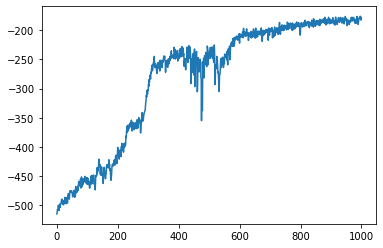

In [6]:
from math import sqrt

torch.manual_seed(0)

obs_dim = 3
action_dim = 2
model = ActorCritic(obs_dim, action_dim)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

l = len(ref_traj)
score_hist = []
for rollout in range(1000):
    score = 0
    hist = []
    s = ref_traj[0]
    for i in range(l):
        s = torch.FloatTensor(s)
        _, a, _ = model.pi(s)
        #s_prime = ref_traj[(i+1)%l]
        y = ref_traj[(i+1)%l]
        expected_pos = a.detach().numpy()
        r = -sqrt((y[1] - expected_pos[0])**2 + (y[2] - expected_pos[1])**2)
        s_prime = [y[0], expected_pos[0], expected_pos[1]]
        score += r
        hist.append((s.tolist(), a.tolist(), r, s_prime))
        s = s_prime

    train(model, optimizer, hist)

    score_hist.append(score)
    print(f'#{rollout} finished | score : {score}')
plt.plot(score_hist)

In [7]:
net_out = []
for i in range(l-1):
    s = ref_traj[i]
    s = torch.FloatTensor(s)
    a, _, _ = model.pi(s)
    expected_pos = a.detach().tolist()
    net_out.append((expected_pos[0], expected_pos[1]))

x_t, y_t = zip(*net_out)
#plt.plot(x_t,y_t)
#t, x, y = zip(*ref_traj)
#plt.plot(x,y)

## with Trajectory Generator

In [8]:
def TG(t, a_x, a_y):
    x = a_x * sin(2*pi*t)
    y = a_y / 2 * sin(2*pi*t) * cos(2*pi*t)
    
    return x, y

#0 finished | score : -549.1064583272523
#1 finished | score : -547.4848391088141
#2 finished | score : -532.9352539291847
#3 finished | score : -526.874623341948
#4 finished | score : -538.0626393917163
#5 finished | score : -526.8813339417651
#6 finished | score : -520.5268166815471
#7 finished | score : -521.7104696316894
#8 finished | score : -520.2019671393862
#9 finished | score : -507.93001991611357
#10 finished | score : -522.7318315889801
#11 finished | score : -513.3752739173792
#12 finished | score : -523.4836392507892
#13 finished | score : -532.8053583845889
#14 finished | score : -538.2400543809568
#15 finished | score : -532.0872475168703
#16 finished | score : -523.3021092547592
#17 finished | score : -527.8545795192595
#18 finished | score : -519.23155014412
#19 finished | score : -519.8519201299662
#20 finished | score : -518.0729718303122
#21 finished | score : -511.3325423108092
#22 finished | score : -524.5903101634873
#23 finished | score : -523.7236892000841
#24 

#194 finished | score : -494.06723810886587
#195 finished | score : -505.8719520853202
#196 finished | score : -502.44256185793984
#197 finished | score : -517.3739904917456
#198 finished | score : -518.0081995801004
#199 finished | score : -513.3137763093164
#200 finished | score : -515.6579123164537
#201 finished | score : -516.0828341044755
#202 finished | score : -513.5571714180364
#203 finished | score : -507.97625612640996
#204 finished | score : -515.4228137223682
#205 finished | score : -508.07495062113753
#206 finished | score : -509.3438840457769
#207 finished | score : -511.27489210785166
#208 finished | score : -492.10979596669836
#209 finished | score : -485.3927257911906
#210 finished | score : -486.5240425994322
#211 finished | score : -484.31698206891673
#212 finished | score : -492.13975391062195
#213 finished | score : -493.2670677131052
#214 finished | score : -489.3063772579562
#215 finished | score : -491.0675325991933
#216 finished | score : -484.2614661390084
#21

#384 finished | score : -468.03403547737673
#385 finished | score : -474.74392006945607
#386 finished | score : -464.00817301538723
#387 finished | score : -466.9637093261051
#388 finished | score : -457.38809253896926
#389 finished | score : -450.83799027298085
#390 finished | score : -456.75410618859036
#391 finished | score : -451.66369036742066
#392 finished | score : -455.31478791191597
#393 finished | score : -447.4622513625736
#394 finished | score : -453.5918363027971
#395 finished | score : -450.1673626181302
#396 finished | score : -443.9185316923619
#397 finished | score : -434.9539603877106
#398 finished | score : -430.27959921530197
#399 finished | score : -423.2235173373556
#400 finished | score : -429.4499303870405
#401 finished | score : -430.11705714066
#402 finished | score : -415.448993071581
#403 finished | score : -408.0253471309054
#404 finished | score : -405.13337312495094
#405 finished | score : -394.85719146434377
#406 finished | score : -386.8626324950607
#40

#572 finished | score : -215.85015957019135
#573 finished | score : -214.84526064141625
#574 finished | score : -206.41566927763822
#575 finished | score : -214.39208614753193
#576 finished | score : -213.2133953380077
#577 finished | score : -210.2746810392483
#578 finished | score : -208.8296911321027
#579 finished | score : -211.43809723484245
#580 finished | score : -216.40178729560193
#581 finished | score : -208.84947303519183
#582 finished | score : -214.25472850312678
#583 finished | score : -220.3820446106529
#584 finished | score : -210.27759171358633
#585 finished | score : -214.37628006400539
#586 finished | score : -218.94705568180382
#587 finished | score : -211.61468302969075
#588 finished | score : -211.14717742890923
#589 finished | score : -210.96369396381178
#590 finished | score : -214.09446428298722
#591 finished | score : -216.51504339861097
#592 finished | score : -218.02358402100228
#593 finished | score : -214.8121269687906
#594 finished | score : -212.77413626

#760 finished | score : -194.28199545788107
#761 finished | score : -191.51911999990494
#762 finished | score : -200.41094969884506
#763 finished | score : -190.2093631379656
#764 finished | score : -192.37146076108866
#765 finished | score : -196.11021411910107
#766 finished | score : -201.62527542740997
#767 finished | score : -190.27327729199172
#768 finished | score : -197.82849131397248
#769 finished | score : -190.60566249198027
#770 finished | score : -196.5637473133413
#771 finished | score : -193.4840703905323
#772 finished | score : -197.89018611426957
#773 finished | score : -194.48700456516093
#774 finished | score : -193.75849659208393
#775 finished | score : -196.20377762459765
#776 finished | score : -192.9757084541697
#777 finished | score : -198.8566715125992
#778 finished | score : -190.73384592141332
#779 finished | score : -193.5278068841937
#780 finished | score : -191.9568897296907
#781 finished | score : -192.74682077435156
#782 finished | score : -201.0052637889

#948 finished | score : -196.68743392180815
#949 finished | score : -190.17828264319215
#950 finished | score : -188.12650631441704
#951 finished | score : -196.66783063747417
#952 finished | score : -193.6854529835915
#953 finished | score : -198.132595423313
#954 finished | score : -193.93653112755425
#955 finished | score : -195.99073530486714
#956 finished | score : -193.36734435563218
#957 finished | score : -191.01233303350858
#958 finished | score : -196.0777766158291
#959 finished | score : -191.36570141338905
#960 finished | score : -193.78422868855085
#961 finished | score : -193.82790049167104
#962 finished | score : -192.9848124962166
#963 finished | score : -188.21316970472256
#964 finished | score : -195.62411378117338
#965 finished | score : -190.80732945719075
#966 finished | score : -190.74815181312977
#967 finished | score : -193.70894458314055
#968 finished | score : -192.55718210955854
#969 finished | score : -195.2288465340239
#970 finished | score : -191.951555448

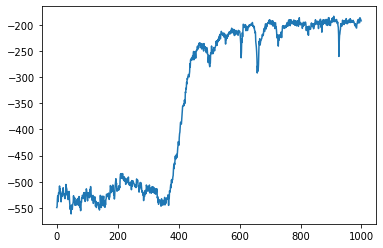

In [9]:
obs_dim = 5
action_dim = 4
model2 = ActorCritic(obs_dim, action_dim)
lr = 0.0001
optimizer2 = optim.Adam(model2.parameters(), lr=lr)

l = len(ref_traj)
score_hist = []
for rollout in range(1000):
    score = 0
    hist = []
    a = [0,0]
    s = ref_traj[0]
    s = s.tolist()
    s.extend(a[0:2])
    for i in range(l):
        s = torch.FloatTensor(s)
        _, a, _ = model2.pi(s)
        a = a.detach().tolist()
        tg_x, tg_y = TG(ref_traj[i][0], a[0], a[1])
        y = ref_traj[(i+1)%l]
        expected_pos = [a[2] + tg_x, a[3] + tg_y]
        r = -sqrt((y[1] - expected_pos[0])**2 + (y[2] - expected_pos[1])**2)
        s_prime = [y[0], expected_pos[0], expected_pos[1], a[0], a[1]]
        score += r
        hist.append((s.tolist(), a, r, s_prime))
        s = s_prime

    train(model2, optimizer2, hist)

    score_hist.append(score)
    print(f'#{rollout} finished | score : {score}')
plt.plot(score_hist)

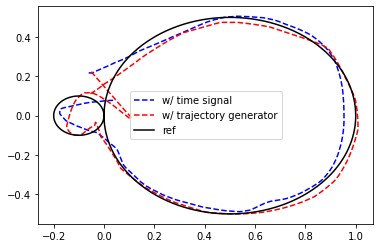

In [10]:
net_out = []
a = [0,0]
s = ref_traj[i].tolist()
s.extend(a[0:2])
for i in range(l):    
    s = torch.FloatTensor(s)
    a, _, _ = model2.pi(s)
    a = a.tolist()
    tg_x, tg_y = TG(ref_traj[i][0], a[0], a[1])
    expected_pos = [a[2] + tg_x, a[3] + tg_y]
    net_out.append((expected_pos[0], expected_pos[1]))
    y = ref_traj[(i+1)%l]
    s_prime = [y[0], expected_pos[0], expected_pos[1], a[0], a[1]]
    s = s_prime

plt.plot(x_t, y_t, 'b--')
x, y = zip(*net_out)
plt.plot(x,y, 'r--')
t, x, y = zip(*ref_traj)
plt.plot(x,y, 'k')
plt.legend(['w/ time signal', 'w/ trajectory generator', 'ref'])